# Life-Cycle Labor Supply

Solves and simulates a $T$-period labor supply model with consumption-saving in Keane(2016).

The **Bellman equation** and the recursive formulation of the model is 

$$
\begin{align}
V_{t}(a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho V_{t+1}(a_{t+1},k_{t+1}) \\
& \text{s.t.} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =&k_{t}+h_{t}
\end{align}
$$
such that wages are endogenous
$$
\begin{align}
w_{t}&=w\left(1+\alpha k_{t}\right)\\
&=w\left(1+\alpha\sum_{s=1}^{t-1}h_{s}\right).
\end{align}
$$

We will solve this by **backwards induction**, assuming no bequest motive. The last-period problem becomes
$$
\begin{align}
V_{T}(a_T,k_T)=&\max_{h_{T}}\frac{c_{T}^{1+\eta}}{1+\eta}-\beta\frac{h_{T}^{1+\gamma}}{1+\gamma} \\
& \text{s.t.} \\
c_T = &a_{T}+(1-\tau)w_{T}h_{T}.
\end{align}
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from DynLaborModel import DynLaborModelClass
model = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.0}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

**Grids:** $\overrightarrow{a}$ and $\overrightarrow{k}$

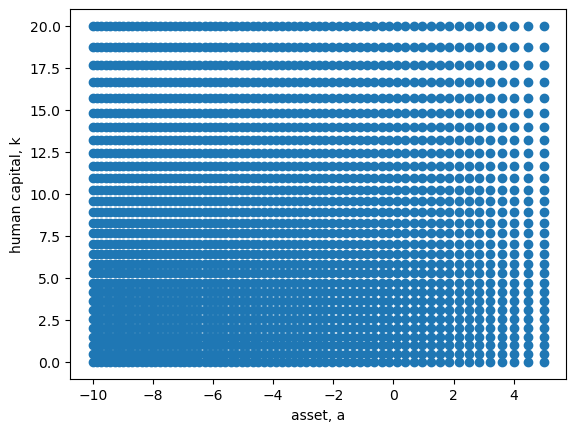

In [3]:
fig, ax = plt.subplots()
a_mesh,k_mesh = np.meshgrid(par.a_grid,par.k_grid,indexing='ij')
ax.scatter(a_mesh,k_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

## Solve the model

In [4]:
%time model.solve()

CPU times: total: 31.2 s
Wall time: 32.9 s


**Last period, $t=T$**

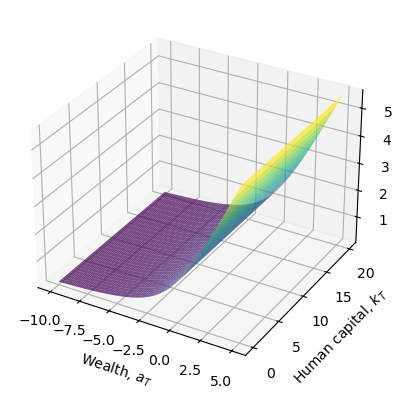

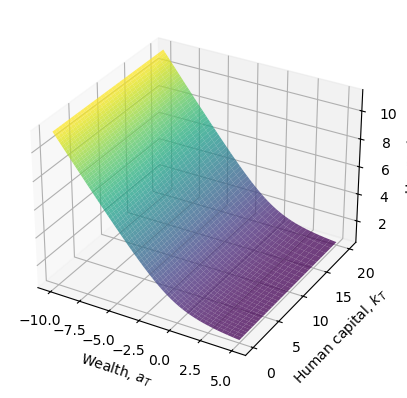

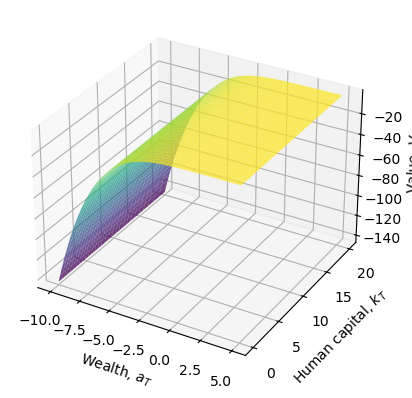

In [5]:
# last period
t = par.T-1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.c[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.h[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.V[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

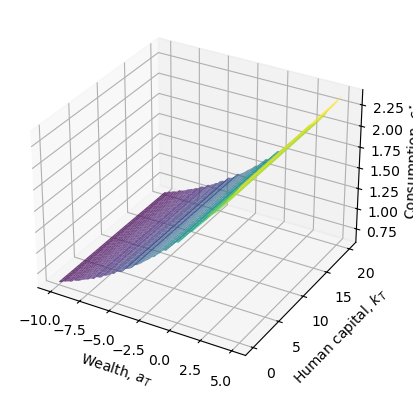

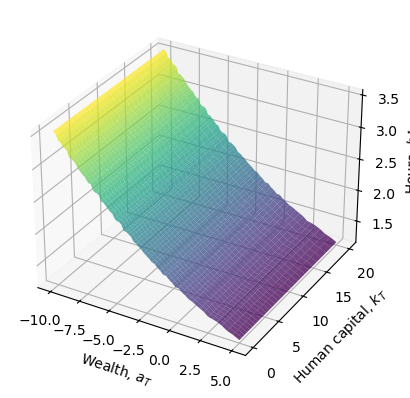

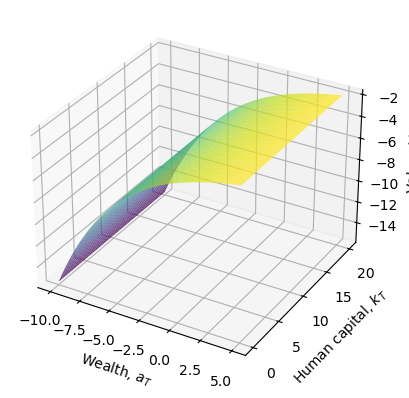

In [6]:
# first period
t = 0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.c[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.h[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.V[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial wealth and human capital are the state variables in our model, and we start by initilizing all individuals with no wealth, `sim.a_init=np.zeros(par.simN)` and no human capital `sim.k_init=np.zeros(par.simN)`. We then loop forward using the solution:
$$
\begin{align}
c_{i,t} &= c_t^{\star}(a_{i,t},k_{i,t}) \\
h_{i,t} &= h_t^{\star}(a_{i,t},k_{i,t}) \\
y_{i,t} &= (1-\tau) \cdot  w\cdot(1+\alpha k_{i,t}) \cdot h_{i,t}\\
a_{i,t+1} &= (1+r)(a_{i,t} + y_{i,t} - c_{i,t})\\
k_{i,t+1} &= k_{i,t} + h_{i,t}\\
\end{align}
$$

In [7]:
model.simulate()

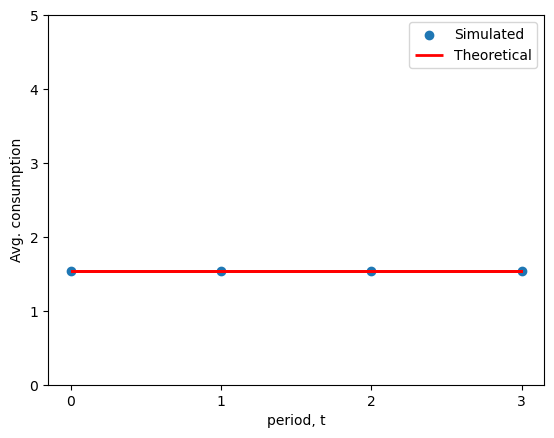

In [8]:
# plot consumption
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0),label='Simulated')
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,5],xticks=range(par.simT));

# add theoretical consumption. Should overlap if rho=1/(1+r)
comp_int = np.tile([(1+par.r)**(par.T-t) for t in reversed(range(par.T))] , (par.simN,1))
C_theo = np.nansum(model.wage_func(sim.k,0)*sim.h * comp_int,axis=1)/np.nansum(comp_int,axis=1)[0]
ax.hlines(y=C_theo, xmin=0, xmax=par.T-1, linewidth=2, color='r',label='Theoretical');
ax.legend();

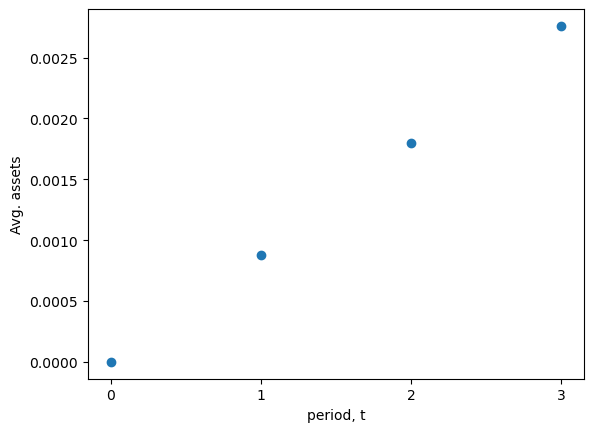

In [9]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',xticks=range(par.simT));

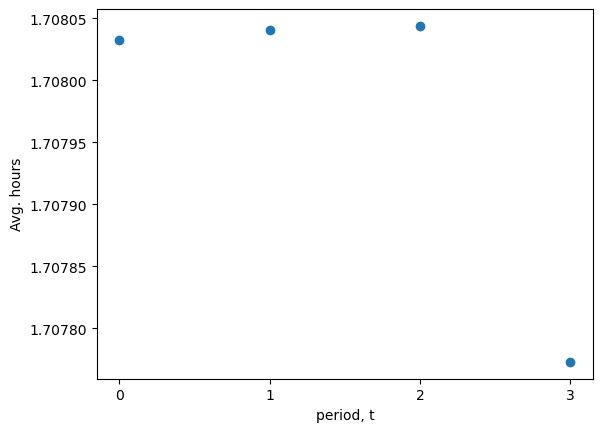

In [10]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.h,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. hours',xticks=range(par.simT));

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Elasticities and Responsiveness

**Marshall**

In [11]:
# simulate Marshall elasticity in the first period
model_1pct = model.copy()
model_1pct.par.w_vec[:] = model_1pct.par.w_vec[:]*1.01

model_1pct.solve()
model_1pct.simulate()

In [12]:
ela_Mi = (model_1pct.sim.h - model.sim.h)/model.sim.h*100
# Theoretical Marshall elasticity if \alpha=0
ela_M_noHC = (1+par.eta) / (par.gamma - par.eta) 

print(f'Theoretical, w. alpha = 0.0:        {ela_M_noHC:2.3f} \nSimulated elasticity, w. alpha={par.alpha:2.1f}: {ela_Mi[0,0]:2.3f}')

Theoretical, w. alpha = 0.0:        -0.222 
Simulated elasticity, w. alpha=0.0: -0.222


**Frisch**

Here, we will experience the joy of numerical solutions...

In [13]:
# simulate Frisch elasticity in the 1st period: Anticipated transitory increase in wage
pct = 1
model_F = model.copy()
model_F.par.w_vec[0] = model_F.par.w_vec[0]*(1.0 +pct/100) # increase by 1% in first period -> easiest because we do not need two models

model_F.solve()
model_F.simulate()

In [14]:
ela_Fi = (model_F.sim.h - model.sim.h)/model.sim.h*100
# Theoretical if no human capital
ela_F_noHC = 1/par.gamma

print(f'Theoretical, w. alpha = 0.0:        {ela_F_noHC:2.3f} \nSimulated elasticity, w. alpha={par.alpha:2.1f}: {ela_Fi[0,0]:2.3f}')
# way of... Seems an artifact of some numerical inaccuracy (see below)

Theoretical, w. alpha = 0.0:        0.400 
Simulated elasticity, w. alpha=0.0: 0.081


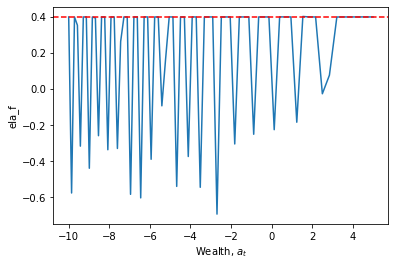

In [15]:
# check model solution [first point in human capital grid]
t = 0
diff = (model_F.sol.h[t] - model.sol.h[t])/model.sol.h[t]/(pct/100)
fig, ax = plt.subplots()
ax.plot(par.a_grid, diff[:,0]);
ax.axhline(ela_F_noHC, color='r', linestyle='--',label='Theoretical');
ax.set(xlabel='Wealth, $a_{t}$',ylabel='ela_f');

In [16]:
# If we had initialized people with a bit of wealth, we wouldn't have seen this issue
model2 = model.copy()
model2.sim.a_init[:] = 0.8
model2.solve()
model2.simulate()

model_F2 = model.copy()
model_F2.par.w_vec[0] = model_F2.par.w_vec[0]*(1.0 +pct/100) # increase by 1% in first period -> easiest because we do not need two models
model_F2.sim.a_init[:] = 0.8

model_F2.solve()
model_F2.simulate()
ela_Fi2 = (model_F2.sim.h - model2.sim.h)/model2.sim.h*100

print(f'Theoretical, w. alpha = 0.0:        {ela_F_noHC:2.3f} \nSimulated elasticity, w. alpha={par.alpha:2.1f}: {ela_Fi2[0,0]:2.3f}')

Theoretical, w. alpha = 0.0:        0.400 
Simulated elasticity, w. alpha=0.0: 0.399
